# This is a environment to test, prototype, and develop CCBA Library.

In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sys.path.insert(0, '/Users/Kwat/binf/ccba')
import ccbal

%matplotlib inline
%config InlineBackend.figure_formats = {'svg', }

================ Computational Cancer Biology Analysis Library ================

<13:04:06.875942> Checking dependencies ...
<13:04:06.878128> Using the following packages:
<13:04:06.879804> 	matplotlib v1.5.1
<13:04:06.879822> 	numpy v1.10.4
<13:04:06.879831> 	pandas v0.18.0
<13:04:06.879852> 	rpy2 v2.7.9
<13:04:06.879860> 	scikit-learn v0.17.1
<13:04:06.879867> 	scipy v0.17.0
<13:04:06.879874> 	seaborn v0.7.0


# Make test data

In [2]:
FONT1 = ccbal.visualize.FONT1
FONT2 = ccbal.visualize.FONT2
FONT3 = ccbal.visualize.FONT3
font1=FONT1
font2=FONT2
font3=FONT3

CMAP_CONTINUOUS = ccbal.visualize.CMAP_CONTINUOUS
CMAP_CATEGORICAL = ccbal.visualize.CMAP_CATEGORICAL
CMAP_BINARY = ccbal.visualize.CMAP_BINARY

In [3]:
nrow = 10
ncol = 10
row_names = ['feature {}'.format(i) for i in range(nrow)]
col_names = ['elemenet {}'.format(i) for i in range(ncol)]

In [4]:
features = pd.DataFrame(np.random.random((nrow, ncol)),
                        index=row_names,
                        columns=col_names)
features

,elemenet 0,elemenet 1,elemenet 2,elemenet 3,elemenet 4,elemenet 5,elemenet 6,elemenet 7,elemenet 8,elemenet 9
feature 0,0.641671,0.078398,0.619363,0.073353,0.927461,0.074472,0.526825,0.222951,0.938291,0.319887
feature 1,0.562711,0.711935,0.800841,0.927926,0.367775,0.800474,0.958237,0.070328,0.640508,0.623882
feature 2,0.690047,0.848537,0.496598,0.542025,0.135598,0.177028,0.104709,0.275421,0.610765,0.473666
feature 3,0.475330,0.174824,0.351741,0.122255,0.820258,0.661665,0.809699,0.742789,0.330848,0.959918
feature 4,0.242024,0.903248,0.435109,0.959468,0.103444,0.687523,0.677051,0.949910,0.678820,0.538319
feature 5,0.276626,0.103817,0.358081,0.365542,0.019706,0.898496,0.425032,0.640500,0.299692,0.208339
feature 6,0.848260,0.565736,0.255635,0.093567,0.977455,0.471960,0.010001,0.974496,0.875663,0.979337
feature 7,0.427675,0.169137,0.522758,0.364323,0.824198,0.691108,0.618870,0.695244,0.322936,0.900806
feature 8,0.660153,0.398646,0.174702,0.141415,0.074977,0.645444,0.840298,0.092962,0.872947,0.670162
feature 9,0.472527,0.778417,0.069230,0.804898,0.960481,0.560793,0.770018,0.300329,0.486987,0.927758


In [5]:
scores = pd.DataFrame(np.random.rand(nrow), index=row_names, columns=['p-value'])
scores

,p-value
feature 0,0.259425
feature 1,0.812566
feature 2,0.764992
feature 3,0.335554
feature 4,0.684420
feature 5,0.882855
feature 6,0.976694
feature 7,0.375169
feature 8,0.641815
feature 9,0.156059


In [6]:
ref_type = 'categorical'
if ref_type == 'continuous':
    ref = pd.DataFrame(np.random.rand(ncol), index=col_names, columns=['Reference']).T
else:
    if ref_type == 'categorical':
        n_category = 4
    elif ref_type == 'binary':
        n_category = 1
    ref = pd.DataFrame(np.random.random_integers(0, n_category, ncol), index=col_names, columns=['Reference']).T
ref

,elemenet 0,elemenet 1,elemenet 2,elemenet 3,elemenet 4,elemenet 5,elemenet 6,elemenet 7,elemenet 8,elemenet 9
Reference,2,1,1,0,3,2,0,0,0,3


Sorted ref.columns: Index(['elemenet 4', 'elemenet 9', 'elemenet 0', 'elemenet 5', 'elemenet 1',
       'elemenet 2', 'elemenet 3', 'elemenet 6', 'elemenet 7', 'elemenet 8'],
      dtype='object')
Sorted features.columns: Index(['elemenet 4', 'elemenet 9', 'elemenet 0', 'elemenet 5', 'elemenet 1',
       'elemenet 2', 'elemenet 3', 'elemenet 6', 'elemenet 7', 'elemenet 8'],
      dtype='object')
boundaries: [0, 2, 4, 6, 10]
label_horizontal_positions: [1.0, 3.0, 5.0, 8.0]
0 1.0
1 3.0
2 5.0
3 8.0


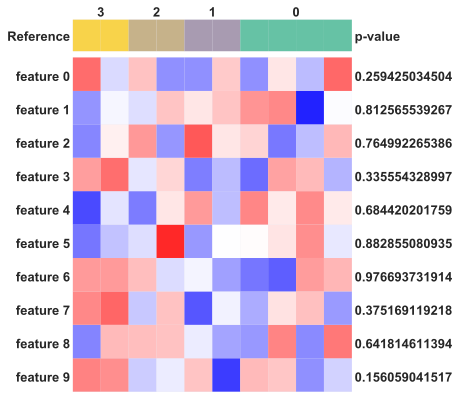

In [20]:
title=None
fig_size = (9, 16)

    # Sort ref and features
    ref = ref.T.sort_values('Reference', ascending=False).T
    print('Sorted ref.columns: {}'.format(ref.columns))
    features = features.reindex_axis(ref.columns, axis=1)
    print('Sorted features.columns: {}'.format(features.columns))

    # Initialize figure
    fig = plt.figure(figsize=figure_size)

    # Set heatmap parameters for ref
    if ref_type == 'binary':
        ref_cmap = CMAP_BINARY
        ref_min, ref_max = 0, 1
    elif ref_type == 'categorical':
        ref_cmap = CMAP_CATEGORICAL
        ref_min, ref_max = 0, np.unique(ref.values).size
    elif ref_type == 'continuous':
        ref_cmap = CMAP_CONTINUOUS
        ref_min, ref_max = -2.5, 2.5
        # Normalize continuous values
        ref = (ref - np.mean(ref)) / np.std(ref)
    else:
        raise ValueError('Unknown ref_type {}.'.format(ref_type))

    # Set heapmap parameters for features and normalize features
    if np.unique(features).size == 2:
        features_cmap = CMAP_BINARY
        features_min, features_max = 0, 1
        # TODO:
        features += 0.1
    else:
        features_cmap = CMAP_CONTINUOUS
        features_min, features_max = -2.5, 2.5
        # Normalize continuous values
        for i, (idx, s) in enumerate(features.iterrows()):
            mean = s.mean()
            std = s.std()
            for j, v in enumerate(s):
                features.iloc[i, j] = (v - mean) / std

    # Get horizontal label positions for binary and categorical data
    if ref_type in ('binary', 'categorical'):
        # Get boundaries
        boundaries = [0]
        prev_v = ref.iloc[0, 0]
        for i, v in enumerate(ref.iloc[0, 1:]):
            if prev_v != v:
                boundaries.append(i + 1)
            prev_v = v
        boundaries.append(ncol)
        print('boundaries: {}'.format(boundaries))

        # Get label horizontal positions
        label_horizontal_positions = []
        prev_b = 0
        for b in boundaries[1:]:
            label_horizontal_positions.append(b - (b - prev_b) / 2)
            prev_b = b
        print('label_horizontal_positions: {}'.format(label_horizontal_positions))

    # Plot ref
    ax1 = plt.subplot2grid((nrow, 1), (0, 0))
    sns.heatmap(ref, vmin=ref_min, vmax=ref_max, robust=True, center=None, mask=None,
                square=False, cmap=ref_cmap, linewidth=0.0, linecolor='b',
                annot=False, fmt=None, annot_kws={}, xticklabels=False,
                yticklabels=[], cbar=False)
    if title:
        ax1.text(ncol / 2, 1.5, title, fontsize=16, horizontalalignment='center', fontweight='bold')
    ax1.text(-0.1, 0.33, ref.index[0], fontsize=13, horizontalalignment='right', fontweight='bold')
    ax1.text(ncol + 0.1, 0.33, scores.columns[0], fontsize=13, horizontalalignment='left', fontweight='bold')
    if ref_type in ('binary', 'categorical'):
        unique_ref_labels = np.unique(ref.values)[::-1]
        for i, pos in enumerate(label_horizontal_positions):
            print(i, pos)
            ax1.text(pos, 1.1, unique_ref_labels[i],
                     fontsize=13, horizontalalignment='center', fontweight='bold')

    # Plot dataframe
    ax2 = plt.subplot2grid((nrow, 1), (0, 1), rowspan=nrow)
    sns.heatmap(features, vmin=features_min, vmax=features_max, robust=True, center=None, mask=None,
                square=False, cmap=features_cmap, linewidth=0.0, linecolor='b',
                annot=False, fmt=None, annot_kws={}, xticklabels=False,
                yticklabels=[], cbar=False)

    for i, idx in enumerate(features.index):
        ax2.text(-0.1, nrow - i - 0.7, idx, fontsize=13, horizontalalignment='right', fontweight='bold')
        ax2.text(ncol + 0.1, nrow - i - 0.7, scores.iloc[i, 0], fontsize=13, fontweight='bold')

    fig.tight_layout()
    plt.show(fig)

# NMF

In [ ]:
nmf_result = ccbal.analyze.nmf(features, [3], plot=True)

In [ ]:
ns, runtimes = ccbal.support.runtime(ccbal.information.information_coefficient, n_range=range(10))

In [ ]:
from scipy.stats import pearsonr
ns, runtimes = ccbal.support.runtime(pearsonr, n_range=range(10))

In [ ]:
# make_heatmap_panel is in the ccba/library/ccba.py
# make_heatmap_panel calls plot_heatmap_panel, which is in the ccba/library/visualize.py
# make_heatmap_panel computes IC of each features's row and the ref (target).
# In the future, we can add other computation within this function so it can compute P-Val and FDR as well.
make_heatmap_panel(features, ref, ['IC', 'P-Val'])

# XXX

In [ ]:
# Feature selection test with real data for IC, CMI diff, and CMI ratio association metrics
## Ranking 60 genes + target profile with respect to the activation profile of KRAS component 6 (BRAF/MAPK)



## Feature selection using Information Coefficient

start_time = time.time()

gct1 = read_gct('/Users/tamayo/UCSD_2015/signatures/paper2/analysis/top_hits.gct', fill_na=0)
gct2 = read_gct('/Users/tamayo/UCSD_2015/signatures/Onco-GPS/CCLE_RNAseq_KRAS_SALE_Late.No_HAEM.k_9.H.v1.gct', fill_na=0)

common_cols = list(set(gct1.columns) & set(gct2.columns))
A = gct1[common_cols]
B = gct2[common_cols]
target = pd.DataFrame(B.loc['KRAS_SALE_Late_Comp_C6_9'])
target = target.T

IC = np.zeros(A.shape[0])
for i in range(A.shape[0]):
    IC[i] = round(compute_information_coefficient(x=target.iloc[0,:], y=A.iloc[i,:]), 3)  
                
IC_order = list(np.argsort(IC, kind='quicksort'))
IC = IC[IC_order]
A_sorted = A.reindex(A.index[IC_order]) 

end_time = time.time() 
print("Feature selection time %s seconds " % (end_time - start_time))

IC_val = pd.Series(IC[:A.shape[0]], name = "IC")
features = A_sorted.head(A.shape[0])
plot_heatmap_panel_v2(target, features, IC_val, "KRAS component 6 (BRAF/MAPK) co-essential genes")

## Feature selection using CMI diff

start_time = time.time()

gct1 = read_gct('/Users/tamayo/UCSD_2015/signatures/paper2/analysis/top_hits.gct', fill_na=0)
gct2 = read_gct('/Users/tamayo/UCSD_2015/signatures/Onco-GPS/CCLE_RNAseq_KRAS_SALE_Late.No_HAEM.k_9.H.v1.gct', fill_na=0)

common_cols = list(set(gct1.columns) & set(gct2.columns))
A = gct1[common_cols]
B = gct2[common_cols]
target = pd.DataFrame(B.loc['KRAS_SALE_Late_Comp_C6_9'])
target = target.T

CMI_diff_vals = np.zeros(A.shape[0])
for i in range(A.shape[0]):
    CMI_diff_vals[i] = round(CMI_diff(x=target.iloc[0,:], y=A.iloc[i,:]), 3)  
                
CMI_order = list(np.argsort(CMI_diff_vals, kind='quicksort'))
CMI_diff_vals = CMI_diff_vals[CMI_order]
A_sorted = A.reindex(A.index[CMI_order]) 

end_time = time.time() 
print("Feature selection time %s seconds " % (end_time - start_time))

CMI_val = pd.Series(CMI_diff_vals[:A.shape[0]], name = "CMI diff")
features = A_sorted.head(A.shape[0])
plot_heatmap_panel_v2(target, features, CMI_val, "KRAS component 6 (BRAF/MAPK) co-essential genes")

## Feature selection using CMI ratio

start_time = time.time()


gct1 = read_gct('/Users/tamayo/UCSD_2015/signatures/paper2/analysis/top_hits.gct', fill_na=0)
gct2 = read_gct('/Users/tamayo/UCSD_2015/signatures/Onco-GPS/CCLE_RNAseq_KRAS_SALE_Late.No_HAEM.k_9.H.v1.gct', fill_na=0)

common_cols = list(set(gct1.columns) & set(gct2.columns))
A = gct1[common_cols]
B = gct2[common_cols]
target = pd.DataFrame(B.loc['KRAS_SALE_Late_Comp_C6_9'])
target = target.T

CMI_ratio_vals = np.zeros(A.shape[0])
for i in range(A.shape[0]):
    CMI_ratio_vals[i] = round(CMI_ratio(x=target.iloc[0,:], y=A.iloc[i,:]), 3)  
                
CMI_order = list(np.argsort(CMI_ratio_vals, kind='quicksort'))
CMI_ratio_vals = CMI_ratio_vals[CMI_order]
A_sorted = A.reindex(A.index[CMI_order]) 

end_time = time.time() 
print("Feature selection time %s seconds " % (end_time - start_time))

CMI_val = pd.Series(CMI_ratio_vals[:A.shape[0]], name = "CMI ratio")
features = A_sorted.head(A.shape[0])

plot_heatmap_panel_v2(target, features, CMI_val, "KRAS component 6 (BRAF/MAPK) co-essential genes")